___

# Aula 06 Bonus - Regressão Linear utilizando o Gradiente Descendente

___

<div id="base"></div>

## Peso vs Consumo

Neste exercício, usaremos o conjunto de dados [Automobile Data](https://www.kaggle.com/datasets/toramky/automobile-dataset), que é uma compilação de dados do *1985 Ward's Automotive Yearbook* e de informações fornecidas por companhias de seguro da época. Inicialmente, estamos especialmente interessados nas *features* *curb-weight* (o peso total de um veículo com o tanque cheio, sem contar os passageiros) e *highway-mpg* (o consumo de combustível do veículo, em milhas por galão).

___

<div id="problema"></div>

### Problema

Considere que o objetivo aqui seja **explicar/prever** qual será o consumo de combustível do veículo utilizando como base o peso total deste veículo com o tanque cheio.

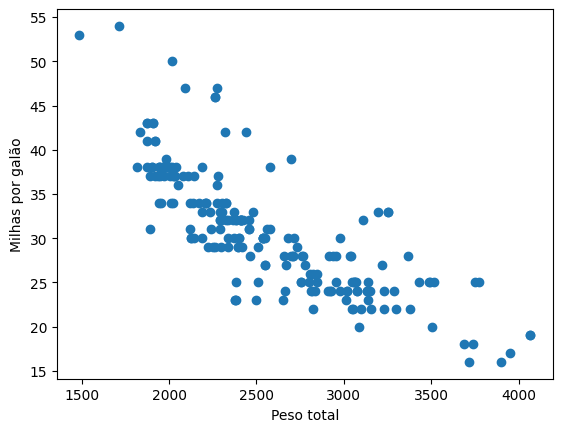

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Automobile_data.csv')
features = ["highway-mpg", "curb-weight"]
df = df[features]

plt.figure()
plt.scatter(df['curb-weight'], df['highway-mpg'])
plt.xlabel('Peso total')
plt.ylabel('Milhas por galão')
plt.show()

Pelos dados, podemos perceber que existe uma relação entre o peso e o consumo. No entanto, não temos como saber **exatamente** quais são os parâmetros "reais" dessa influência do peso no consumo - na verdade, não sabemos nem ao certo que esse relação obedece a alguma equação.

Existem diversas possíveis retas que podemos utilizar para tentar modelar essa relação. Veja abaixo. É possível identificar qual representa melhor os dados somente olhando?

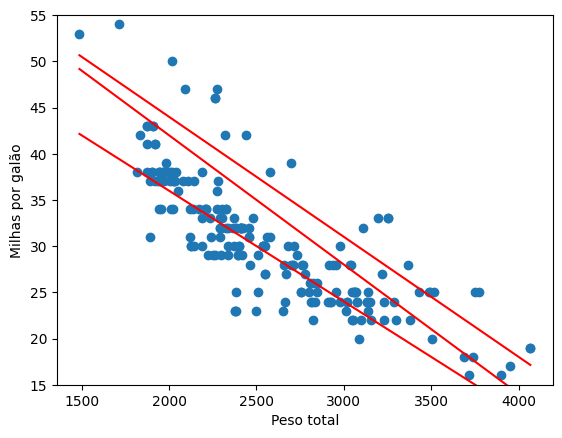

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Automobile_data.csv')
features = ["highway-mpg", "curb-weight"]
df = df[features]

x = np.linspace(1488, 4066, 5)
h1 = -0.013*x + 70
h2 = -0.012*x + 60
h3 = -0.014*x + 70

plt.figure()
plt.scatter(df['curb-weight'], df['highway-mpg'])
plt.plot(x, h1, c='red')
plt.plot(x, h2, c='red')
plt.plot(x, h3, c='red')
plt.ylim(15,55)
plt.xlabel('Peso total')
plt.ylabel('Milhas por galão')
plt.show()

Para escolher uma reta, queremos usar um critério objetivo, isto é, encontrar um número que nos diga o quão bom é um modelo (uma reta). Uma das propostas mais comuns para isso é o **erro quadrático médio**, ou EQM, que funciona da seguinte forma:

    Para cada ponto medido (x,y), com o modelo y_est=a*x_medido+b:
        estime o valor fornecido pelo modelo y_est = a*x_medido + b
        calcule o erro quadrático EQ = (y_est-y_medido)**2
    
    Após:
        calcule o EQM como a média de todos os EQs

Outra maneira de entender o EQM é como uma equação:

$$
\text{EQM} = \frac{1}{N} \sum_{n=1}^N (y_n - (ax_n + b))^2
$$

Vamos calcular os erros de cada uma das retas apresentadas acima:

In [4]:
def erro( parametros ):
    medidas_x, medidas_y, coef_angular_modelo, coef_linear_modelo = parametros
    return np.mean((medidas_y - (coef_angular_modelo * medidas_x + coef_linear_modelo))**2)

h1 = -0.013*x + 70
h2 = -0.012*x + 60
h3 = -0.014*x + 70

erro_h1 = erro([df['curb-weight'], df['highway-mpg'], -0.013, 70])
erro_h2 = erro([df['curb-weight'], df['highway-mpg'], -0.012, 60])
erro_h3 = erro([df['curb-weight'], df['highway-mpg'], -0.014, 70])

print("O erro do modelo h1 é", erro_h1)
print("O erro do modelo h2 é", erro_h2)
print("O erro do modelo h3 é", erro_h3)

O erro do modelo h1 é 55.12109625853661
O erro do modelo h2 é 19.760360039024395
O erro do modelo h3 é 32.44343205853658


___

Com isso, podemos afirmar numericamente que o modelo h2 é um modelo melhor, pois a reta h2 tem o menor EQM dentre as três. No entanto, geralmente não é suficiente saber que uma reta é melhor que a outra. Queremos saber qual é a melhor reta possível, ou seja, qual é a reta que minimiza o EQM.

Para isso, vamos utilizar o método de descida pelo gradiente para encontrar os coeficientes da reta que minimizam o EQM.

In [5]:
import autograd.numpy as np_
from autograd import grad

def erro( parametros ):
    coef_angular_modelo, coef_linear_modelo, medidas_x, medidas_y = parametros
    return np_.mean((medidas_y - (coef_angular_modelo * medidas_x + coef_linear_modelo))**2)

g = grad(erro) # Derivada da função de erro

a_modelo, b_modelo = 0.0, 0.0
alpha = 0.01

modelos_testados = []
for i in range(10): # por 10 iterações...
    gradiente = g( (a_modelo, b_modelo, df['curb-weight'].astype(float).to_numpy(), df['highway-mpg'].astype(float).to_numpy()) ) # Calcula o gradiente
    a_modelo = a_modelo - alpha * gradiente[0] # Atualiza o modelo
    b_modelo = b_modelo - alpha * gradiente[1] # Atualiza o modelo
    modelos_testados.append((a_modelo, erro((a_modelo, b_modelo, df['curb-weight'].astype(float).to_numpy(), df['highway-mpg'].astype(float).to_numpy())), i)) # Guarda o modelo testado

modelos_testados = pd.DataFrame(modelos_testados, columns=['coef_angular', 'erro', 'iteracao'])
modelos_testados


,coef_angular,erro,iteracao
0,1.514826e+03,1.560533e+13,0
1,-2.060346e+08,2.886917e+23,1
2,2.802340e+13,5.340667e+33,2
3,-3.811548e+18,9.879995e+43,3
4,5.184204e+23,1.827755e+54,4
5,-7.051194e+28,3.381265e+64,5
6,9.590545e+33,6.255189e+74,6
7,-1.304439e+39,1.157182e+85,7
8,1.774208e+44,2.140735e+95,8
9,-2.413155e+49,3.960265e+105,9


Perceba o problema acima. Quanto mais avançamos nas iterações, maior é o nosso erro. Isso ocorre porque estamos utilizando um passo muito grande para atualizar os coeficientes. Para resolver isso, podemos utilizar um passo menor, ou seja, multiplicar o gradiente por um número menor.

In [6]:
import autograd.numpy as np_
from autograd import grad

def erro( parametros ):
    coef_angular_modelo, coef_linear_modelo, medidas_x, medidas_y = parametros
    return np_.mean((medidas_y - (coef_angular_modelo * medidas_x + coef_linear_modelo))**2)

g = grad(erro)

a_modelo, b_modelo = 0.0, 0.0
alpha = 0.0000001 # PASSO MENOR

modelos_testados = []
for i in range(10):
    gradiente = g( (a_modelo, b_modelo, df['curb-weight'].astype(float).to_numpy(), df['highway-mpg'].astype(float).to_numpy()) ) # Calcula o gradiente
    a_modelo = a_modelo - alpha * gradiente[0]
    b_modelo = b_modelo - alpha * gradiente[1]
    modelos_testados.append((a_modelo, erro((a_modelo, b_modelo, df['curb-weight'].astype(float).to_numpy(), df['highway-mpg'].astype(float).to_numpy())), i)) # Guarda o modelo testado

modelos_testados = pd.DataFrame(modelos_testados, columns=['coef_angular', 'erro', 'iteracao'])
modelos_testados


,coef_angular,erro,iteracao
0,0.015148,258.687255,0
1,0.009693,163.468095,1
2,0.011658,151.118046,2
3,0.010950,149.516227,3
4,0.011205,149.308467,4
5,0.011113,149.281519,5
6,0.011146,149.278022,6
7,0.011134,149.277566,7
8,0.011138,149.277505,8
9,0.011137,149.277496,9


Agora que encontramos um passo que está diminuindo o erro, podemos aumentar o número de iterações para tentar encontrar o melhor modelo possível.

In [7]:
import autograd.numpy as np_
from autograd import grad

def erro( parametros ):
    coef_angular_modelo, coef_linear_modelo, medidas_x, medidas_y = parametros
    return np_.mean((medidas_y - (coef_angular_modelo * medidas_x + coef_linear_modelo))**2)

g = grad(erro)

a_modelo, b_modelo = 0.0, 55.
alpha = 0.0000001
for _ in range(10000): # por 10000 iterações...
    gradiente = g( (a_modelo, b_modelo, df['curb-weight'].astype(float).to_numpy(), df['highway-mpg'].astype(float).to_numpy()) ) # Calcula o gradiente
    a_modelo = a_modelo - alpha * gradiente[0] # Atualiza o modelo
    b_modelo = b_modelo - alpha * gradiente[1] # Atualiza o modelo
    
print("MSE do modelo final:", erro((a_modelo, b_modelo, df['curb-weight'].astype(float).to_numpy(), df['highway-mpg'].astype(float).to_numpy())))
print("Coeficiente angular:", a_modelo)
print("Coeficiente linear:", b_modelo)

MSE do modelo final: 17.470418362896154
Coeficiente angular: -0.009530686904331037
Coeficiente linear: 55.00021104007988


___
Vamos visualizar o modelo final obtido:

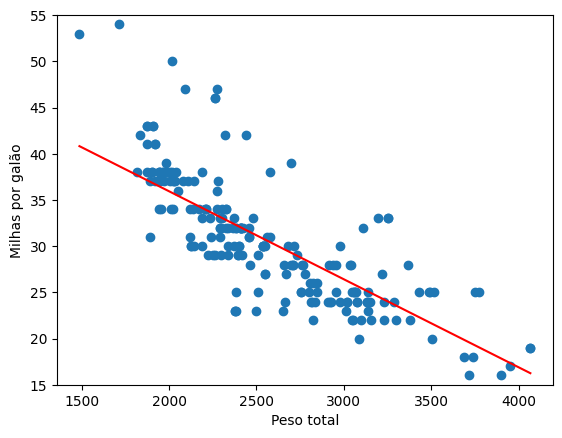

In [8]:
x = np.linspace(1488, 4066, 5)
h1 = a_modelo*x + b_modelo

plt.figure()
plt.scatter(df['curb-weight'], df['highway-mpg'])
plt.plot(x, h1, c='red')
plt.ylim(15,55)
plt.xlabel('Peso total')
plt.ylabel('Milhas por galão')
plt.show()

___

Com base nessa reta, podemos tentar prever o consumo de combustível de um veículo novo.

Se soubermos que esse veículo novo tem um peso de 3600 libras, como podemos prever o consumo de combustível dele?

O consumo estimado para um carro de 3600 libras é 20.68973818448815 milhas por galão


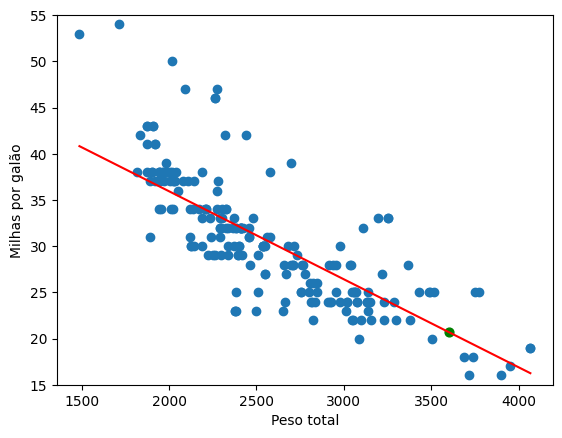

In [9]:
peso = 3600
consumo = a_modelo*peso + b_modelo

print("O consumo estimado para um carro de 3600 libras é", consumo, "milhas por galão")

plt.figure()
plt.scatter(df['curb-weight'], df['highway-mpg'])
plt.plot(x, h1, c='red')
plt.scatter(peso, consumo, c='green', s=40)
plt.ylim(15,55)
plt.xlabel('Peso total')
plt.ylabel('Milhas por galão')
plt.show()

___

## Regressão Linear com múltiplos atributos

Agora, vamos considerar que o consumo de combustível de um veículo pode ser influenciado por mais de um atributo. Por exemplo, além do peso, o consumo pode ser influenciado pela potência do motor e pelo ano de fabricação. Seria interessante tentar prever o consumo de combustível utilizando toda a informação que está dicponível. Da nossa base de dados, usaremos as seguintes informações:

Variável | Descrição
:---:|---:
highway-mpg | consumo em milhas por galão na estrada
price | preço do veículo
horsepower | potência do veículo (HP)
curb-weight | peso do veículo (libras)
engine-size | tamanho do motor (litros)
length | comprimento do veículo
width | largura do veículo
height | altura do veículo

In [12]:
df = pd.read_csv('Automobile_data.csv')
features = ['highway-mpg', 'price', 'horsepower', 
           'curb-weight', 'engine-size', "length", "width", "height"]
df = df.loc[(df.price != '?') & (df.horsepower != '?'),features]

df.head()

,highway-mpg,price,horsepower,curb-weight,engine-size,length,width,height
0,27,13495,111,2548,130,168.8,64.1,48.8
1,27,16500,111,2548,130,168.8,64.1,48.8
2,26,16500,154,2823,152,171.2,65.5,52.4
3,30,13950,102,2337,109,176.6,66.2,54.3
4,22,17450,115,2824,136,176.6,66.4,54.3



Inicialmente, estávamos em uma situação onde prevíamos o consumo através de uma reta:

$consumo = a*peso + b$

Agora, queremos prever o consumo através de um plano:

$consumo = a*peso + b*potencia + c*preco + d*tamanhoMotor + e*comprimento + f*largura + g*altura + h$

Podemos utilizar o mesmo método de descida pelo gradiente para encontrar os coeficientes que minimizam o EQM. No entanto, agora temos mais coeficientes para atualizar. Assim, partimos para a representação matricial do problema:

$consumo = \begin{bmatrix}a & b & c & d & e & f & g\end{bmatrix} * 
\begin{bmatrix}
peso \\ 
potencia \\ 
preco \\ 
tamanhoMotor \\ 
comprimento \\ 
largura \\ 
altura
\end{bmatrix} + h$ = w.T * pontos + h

In [42]:
def eqm( parametros ):
    w, h, pontos, val = parametros
    est = w.T @ pontos + h
    mse = np_.mean( (est - val)**2)
    return mse

g = grad(eqm)

pontos = df[['price', 'horsepower', 'curb-weight', 'engine-size', "length", "width", "height"]]
pontos = pontos.astype(float).to_numpy().T
alvos = df['highway-mpg'].astype(float).to_numpy()

w = np.random.randn( pontos.shape[0],1)
h = 0.0
alpha = 10**-9

erro = eqm( (w, h, pontos, alvos) )
print("Erro do modelo inicial:", eqm( (w, h, pontos, alvos) ))
diferenca = 10
n = 0
for n in range(10000):
    grad_ = g( (w, h, pontos, alvos) )
    w -= alpha*grad_[0]
    h -= alpha*grad_[1]

    if n % 1000 == 0:
        print("Iteração", n, "Erro:", eqm( (w, h, pontos, alvos) ))

print("Erro do modelo final:", eqm( (w, h, pontos, alvos) ))

Erro do modelo inicial: 262288633.30267987
Iteração 0 Erro: 71746895.5649771
Iteração 1000 Erro: 97547.33752379821
Iteração 2000 Erro: 3648.9592647031895
Iteração 3000 Erro: 1648.543466484267
Iteração 4000 Erro: 1602.9219321442724
Iteração 5000 Erro: 1598.887638702847
Iteração 6000 Erro: 1595.7441961294285
Iteração 7000 Erro: 1592.625926870079
Iteração 8000 Erro: 1589.5144039435388
Iteração 9000 Erro: 1586.409222506299
Erro do modelo final: 1583.3134568049459


O modelo acima apresentou um erro **quadrático** médio de aproximadamente 1583. O que significa que, em média, o modelo erra $\sqrt{1583} \approx 39.7$ milhas por galão.

In [44]:
df['highway-mpg'].describe()

count    199.000000
mean      30.683417
std        6.849410
min       16.000000
25%       25.000000
50%       30.000000
75%       34.000000
max       54.000000
Name: highway-mpg, dtype: float64

Vendo a distribuição dos dados, que tem média de 30 milhas por galão e desvio padrão de 6 milhas por galão, podemos dizer que o modelo está errando aproximadamente 6.6 vezes o desvio padrão. Ou seja, o modelo não é tão bom.

In [45]:
pontos = df[['price', 'horsepower', 'curb-weight', 'engine-size', "length", "width", "height"]]

Pode ser que 10000 iterações não sejam suficientes para encontrar o melhor modelo. Podemos tentar aumentar o número de iterações para tentar encontrar o melhor modelo possível. Mas quantas iterações são suficientes? Podemos tentar iterar até que o erro seja aceitável.

In [63]:
def eqm( parametros ):
    w, h, pontos, val = parametros
    est = w.T @ pontos + h
    mse = np_.mean( (est - val)**2)
    return mse

g = grad(eqm)

pontos = df[['price', 'horsepower', 'curb-weight', 'engine-size', "length", "width", "height"]]
pontos = pontos.astype(float).to_numpy().T
alvos = df['highway-mpg'].astype(float).to_numpy()

w = np.random.randn( pontos.shape[0],1)
h = 0.0
alpha = 10**-9

erro = eqm( (w, h, pontos, alvos) )
print("Erro do modelo inicial:", eqm( (w, h, pontos, alvos) ))
diferenca = 10
n = 0
while erro > 6.849410**2: # Erro de um desvio padrão.
    grad_ = g( (w, h, pontos, alvos) )
    w -= alpha*grad_[0]
    h -= alpha*grad_[1]

    erro = eqm( (w, h, pontos, alvos) )
    n += 1
    if n % 10000 == 0:
        print("Iteração", n, "Erro:", eqm( (w, h, pontos, alvos) ))

print("Erro do modelo final:", eqm( (w, h, pontos, alvos) ))

Erro do modelo inicial: 135985460.0271379
Iteração 10000 Erro: 170.17329498724183
Iteração 20000 Erro: 167.72092222977201
Iteração 30000 Erro: 165.31010563397888
Iteração 40000 Erro: 162.9401232721352
Iteração 50000 Erro: 160.6102659515166
Iteração 60000 Erro: 158.3198369873844
Iteração 70000 Erro: 156.06815198015195
Iteração 80000 Erro: 153.85453859654663
Iteração 90000 Erro: 151.67833635469833
Iteração 100000 Erro: 149.5388964130906
Iteração 110000 Erro: 147.4355813632825
Iteração 120000 Erro: 145.3677650263663
Iteração 130000 Erro: 143.3348322530623
Iteração 140000 Erro: 141.3361787274001
Iteração 150000 Erro: 139.3712107739275
Iteração 160000 Erro: 137.43934516836958
Iteração 170000 Erro: 135.54000895168394
Iteração 180000 Erro: 133.6726392474442
Iteração 190000 Erro: 131.83668308250225
Iteração 200000 Erro: 130.03159721086556
Iteração 210000 Erro: 128.2568479407255
Iteração 220000 Erro: 126.51191096458501
Iteração 230000 Erro: 124.79627119243415
Iteração 240000 Erro: 123.109422587

Com um pouco mais de 1 milhão de iterações, alcançamos um modelo que erra em média um desvio padrão, que é um modelo bem superior ao anterior. Poderíamos continuar a aumentar o número de iterações para tentar encontrar um modelo ainda melhor se quiséssemos.

Assim, podemos tentar prever o consumo de combustível de um veículo novo com base em todas as informações disponíveis.

Se soubermos que esse veículo novo tem um peso de 2823 libras, uma potência de 154 HP, um preço de 16500 dólares, um tamanho de motor de 152 litros, um comprimento de 171.2 polegadas, uma largura de 65.5 polegadas e uma altura de 52.4 polegadas, como podemos prever o consumo de combustível dele?

In [66]:
carro = [16500, 154, 2823, 152, 171.2, 65.5, 52.4]
consumo = w.T @ carro + h

print("O consumo estimado para o carro é", consumo[0], "milhas por galão")

O consumo estimado para o carro é 21.099582824504783 milhas por galão
